#Start

Paper - https://arxiv.org/abs/1905.00641

Dataset - http://shuoyang1213.me/WIDERFACE/

Training dataset download link - https://drive.google.com/file/d/15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M/view

Validation dataset download link - https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view

RetinaFace official annotations - https://drive.google.com/file/d/1vgCABX1JI3NGBzsHxwBXlmRjaLV3NIsG/view

In [1]:
import os
import cv2
import json
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from google_drive_downloader import GoogleDriveDownloader as gdd

# Download Dataset and annotations

In [2]:
!mkdir data

In [3]:
#training images
gdd.download_file_from_google_drive(file_id='15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M',
                                    dest_path='/content/data/widertrain.zip',
                                    unzip=True)

Unzipping...Done.


In [4]:
#validation images
gdd.download_file_from_google_drive(file_id='1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q',
                                    dest_path='/content/data/widerval.zip',
                                    unzip=True)

Unzipping...Done.


In [5]:
!mkdir labels

In [6]:
#ground truth labels
gdd.download_file_from_google_drive(file_id='1vgCABX1JI3NGBzsHxwBXlmRjaLV3NIsG',
                                    dest_path='/content/labels/widergt.zip',
                                    unzip=True)

Unzipping...Done.


In [7]:
!cp /content/labels/train/label.txt /content/data/WIDER_train/

In [8]:
!cp /content/labels/val/label.txt /content/data/WIDER_val/

## From official site as well http://shuoyang1213.me/WIDERFACE/

In [9]:
!wget http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

--2022-01-09 10:01:25--  http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip
Resolving shuoyang1213.me (shuoyang1213.me)... 192.30.252.153, 192.30.252.154
Connecting to shuoyang1213.me (shuoyang1213.me)|192.30.252.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  16.6MB/s    in 0.2s    

2022-01-09 10:01:25 (16.6 MB/s) - ‘wider_face_split.zip’ saved [3591642/3591642]



In [10]:
!unzip /content/wider_face_split.zip

Archive:  /content/wider_face_split.zip
   creating: wider_face_split/
  inflating: wider_face_split/readme.txt  
  inflating: wider_face_split/wider_face_test.mat  
  inflating: wider_face_split/wider_face_test_filelist.txt  
  inflating: wider_face_split/wider_face_train.mat  
  inflating: wider_face_split/wider_face_train_bbx_gt.txt  
  inflating: wider_face_split/wider_face_val.mat  
  inflating: wider_face_split/wider_face_val_bbx_gt.txt  


In [11]:
!cp /content/wider_face_split/wider_face_train_bbx_gt.txt /content/data/WIDER_train
!cp /content/wider_face_split/wider_face_val_bbx_gt.txt /content/data/WIDER_val

# Checking Dataset

In [12]:
train_images_folder = '/content/data/WIDER_train/images/'
len(os.listdir(train_images_folder))

61

In [13]:
len(os.listdir(os.path.join(
    train_images_folder, 
    os.listdir(train_images_folder)[0])))

105

In [14]:
im = plt.imread('/content/data/WIDER_train/images/0--Parade/0_Parade_Parade_0_1014.jpg')
im.shape

(732, 1024, 3)

# Preparing dataset

In [16]:
with open('/content/data/WIDER_train/label.txt') as f:
    lines = f.readlines()

In [17]:
lines[:2]

['# 0--Parade/0_Parade_marchingband_1_849.jpg\n',
 '449 330 122 149 488.906 373.643 0.0 542.089 376.442 0.0 515.031 412.83 0.0 485.174 425.893 0.0 538.357 431.491 0.0 0.82\n']

In [18]:
for line in lines:
    if '#' not in line:
        if len(lines[1].split()) != 20:
            print(len(lines[1].split()))

In [19]:
def load_labels(txt_path):
    """load info from label txt"""
    img_paths = []
    labels = []

    with open(txt_path, 'r') as f:
        lines = f.readlines()

    isFirst = True
    labels_image = []
    for line in lines:
        line = line.rstrip()
        if line.startswith('#'):
            if isFirst is True:
                isFirst = False
            else:
                labels_image_copy = labels_image.copy()
                labels.append(labels_image_copy)
                labels_image.clear()
            path = line[2:]
            path = txt_path.replace('label.txt', 'images/') + path
            img_paths.append(path)
        else:
            line = line.split(' ')
            label = [float(x) for x in line]
            labels_image.append(label)

    labels.append(labels_image)
    return img_paths, labels

In [20]:
train_img_paths, train_labels= load_labels('/content/data/WIDER_train/label.txt')

print(len(train_img_paths))
print(len(train_labels))

12880
12880


In [21]:
train_img_paths[:3]

['/content/data/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg',
 '/content/data/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg',
 '/content/data/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg']

In [22]:
for i in train_labels[:3]:
    print(len(i),i)

1 [[449.0, 330.0, 122.0, 149.0, 488.906, 373.643, 0.0, 542.089, 376.442, 0.0, 515.031, 412.83, 0.0, 485.174, 425.893, 0.0, 538.357, 431.491, 0.0, 0.82]]
1 [[361.0, 98.0, 263.0, 339.0, 424.143, 251.656, 0.0, 547.134, 232.571, 0.0, 494.121, 325.875, 0.0, 453.83, 368.286, 0.0, 561.978, 342.839, 0.0, 0.89]]
21 [[78.0, 221.0, 7.0, 8.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.2], [78.0, 238.0, 14.0, 17.0, 84.188, 244.607, 1.0, 89.527, 244.491, 1.0, 86.973, 247.857, 1.0, 85.116, 250.643, 1.0, 88.482, 250.643, 1.0, 0.36], [113.0, 212.0, 11.0, 15.0, 117.0, 220.0, 0.0, 122.0, 220.0, 0.0, 119.0, 222.0, 0.0, 118.0, 225.0, 0.0, 122.0, 225.0, 0.0, 0.3], [134.0, 260.0, 15.0, 15.0, 142.0, 265.0, 0.0, 146.0, 265.0, 0.0, 145.0, 267.0, 0.0, 142.0, 272.0, 0.0, 146.0, 271.0, 0.0, 0.24], [163.0, 250.0, 14.0, 17.0, 169.357, 256.5, 1.0, 175.25, 257.143, 1.0, 172.357, 260.786, 1.0, 170.214, 262.929, 1.0, 174.071, 262.821, 1.0, 0.41], [201.0, 218.0, 10.0, 12.0

In [23]:
samples = list(zip(train_img_paths, train_labels))
random.shuffle(samples)

In [24]:
len(samples)
#samples[:1]

12880

# Testing img and bounding boxes

In [26]:
len(samples)

12880

In [27]:
print(samples[3][0])
for i in samples[3][1]:
    print(i)

/content/data/WIDER_train/images/2--Demonstration/2_Demonstration_Demonstrators_2_688.jpg
[25.0, 607.0, 58.0, 114.0, 71.143, 660.857, 0.0, 78.286, 655.143, 1.0, 79.714, 677.286, 1.0, 68.286, 703.0, 0.0, 74.714, 700.143, 1.0, 0.55]
[211.0, 503.0, 37.0, 57.0, 202.714, 517.786, 1.0, 213.071, 518.143, 1.0, 202.714, 537.786, 1.0, 202.714, 556.357, 1.0, 220.214, 558.857, 1.0, 0.39]
[111.0, 615.0, 87.0, 112.0, 166.902, 654.777, 1.0, 190.179, 654.777, 1.0, 197.938, 678.054, 1.0, 166.196, 695.688, 1.0, 186.652, 697.098, 1.0, 0.67]
[190.0, 589.0, 53.0, 122.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.48]
[335.0, 628.0, 51.0, 82.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.39]
[508.0, 691.0, 37.0, 86.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.43]
[595.0, 636.0, 68.0, 98.0, 619.143, 675.375, 0.0, 647.482, 674.143, 0.0, 633.312, 693.857, 0.0, 621.60

In [28]:
im = cv2.imread(samples[3][0])
im.shape

(808, 1024, 3)

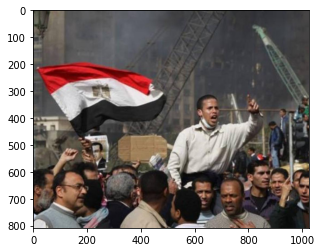

In [29]:
plt.imshow(im[:,:,::-1])

In [30]:
samples[3][1][0][:4]

[25.0, 607.0, 58.0, 114.0]

In [31]:
for s in samples[3][1]:
    x,y,w,h = s[:4]
    cv2.rectangle(im, (int(x), int(y)),(int(x+w), int(y+h)), (0,255,0), 4)

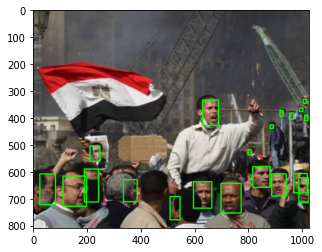

In [32]:
plt.imshow(im[:,:,::-1])

# Model 

In [33]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, ReLU, LeakyReLU, BatchNormalization

In [34]:
input_size = (640,640,3)

## Base Model

In [35]:
base_model = MobileNetV2(input_shape = input_size, include_top=False, weights= 'imagenet')

base_model.trainable = False



9420800/9406464 [==============================] - 0s 0us/step


In [36]:
base_model.layers[143].output

<KerasTensor: shape=(None, 20, 20, 960) dtype=float32 (created by layer 'block_16_expand')>

In [37]:
base_model.input

<KerasTensor: shape=(None, 640, 640, 3) dtype=float32 (created by layer 'input_1')>

In [38]:
pick_layer1 = 54  # [80, 80, 192]
pick_layer2 = 116  # [40, 40, 576]
pick_layer3 = 143  # [20, 20, 960]

In [39]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [40]:
# define model
inputs = Input(input_size, name='input_image')

x = preprocess_input(inputs)
mobilenetv2_layer1_80 = Model(base_model.input, base_model.layers[pick_layer1].output, name = 'mobilenet_layer54_80')(x)
mobilenetv2_layer2_40 = Model(base_model.input, base_model.layers[pick_layer2].output, name = 'mobilenet_layer116_40')(x)
mobilenetv2_layer3_20 = Model(base_model.input, base_model.layers[pick_layer3].output, name = 'mobilenet_layer143_20')(x)

model = Model(inputs,
              (mobilenetv2_layer1_80,
               mobilenetv2_layer2_40,
               mobilenetv2_layer3_20))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 640, 640, 3)  0           ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 640, 640, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 mobilenet_layer54_80 (Function  (None, 80, 80, 192)  65152      ['tf.math.subtract[0][0]']   

In [41]:
1518464 + 613952 + 65152 

2197568

In [42]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


#model.save_weights('model.h5')


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [43]:
# load json and create model
with open('model.json', 'r') as json_file:
    model_json = json_file.read()

model = tf.keras.models.model_from_json(model_json)
# load weights into new model
#model.load_weights("model.h5")

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 640, 640, 3)  0           ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 640, 640, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 mobilenet_layer54_80 (Function  (None, 80, 80, 192)  65152      ['tf.math.subtract[0][0]']   

## Complete Model

In [45]:
def conv_block(prev_layer, name, filters, kernel, stride, act = True):
    x =  Conv2D(filters = filters, 
                kernel_size = kernel, 
                strides = stride, 
                padding='same',
                kernel_initializer = tf.keras.initializers.he_normal(),
                use_bias = False,
                name = name+'conv')(prev_layer)
    
    x = BatchNormalization(epsilon=1e-5,
                           name = name+'batchnorm')(x)

    if act:
        x = ReLU(name = name+'relu')(x)
               
    
    return x

In [46]:
def fpn(input_layer1, input_layer2, input_layer3):
    '''
    feature pyramid network
    '''
    output1 = conv_block(input_layer1,
                        'fpn1_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 80, 80, 64)
    
    output2 = conv_block(input_layer2,
                        'fpn2_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 40, 40, 64)
    
    output3 = conv_block(input_layer3,
                        'fpn3_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 20, 20, 64)
    
    #Up sampling + feature fusion
    up_h2, up_w2 = tf.shape(output2)[1], tf.shape(output2)[2]         #up_h = 40, up_w = 40
    up3 = tf.image.resize(output3, [up_h2, up_w2], method='nearest')   # (None,40,40,64)
    output2 = output2 + up3                                                         # (None,40,40,64)


    merge2 = conv_block(output2,
                        'fpn2_merge_',
                        filters = 64,
                        kernel = 3,
                        stride = 1)                                                  # (None,40,40,64)
    

    #Up sampling + feature fusion
    up_h1, up_w1 = tf.shape(output1)[1], tf.shape(output1)[2]         #up_h = 80, up_w = 80
    up2 = tf.image.resize(merge2, [up_h1, up_w1], method='nearest')   # (None,80,80,64)
    output1 = output1 + up2                                                  # (None,80,80,64)


    merge1 = conv_block(output1,
                        'fpn1_merge_',
                        filters = 64,
                        kernel = 3,
                        stride = 1)                                               # (None,80,80,64)

                        
    return merge1, merge2, output3

In [47]:
o1,o2,o3 = fpn(mobilenetv2_layer1_80, mobilenetv2_layer2_40, mobilenetv2_layer3_20)

print(o1)
print(o2)
print(o3)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 64), dtype=tf.float32, name=None), name='fpn1_merge_relu/Relu:0', description="created by layer 'fpn1_merge_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 64), dtype=tf.float32, name=None), name='fpn2_merge_relu/Relu:0', description="created by layer 'fpn2_merge_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 64), dtype=tf.float32, name=None), name='fpn3_relu/Relu:0', description="created by layer 'fpn3_relu'")


In [48]:
def ssh(prev_layer, name):
    '''
    single stage headless
    '''
    conv_3x3 = conv_block(prev_layer,
                        name = name + 'conv_3x3',
                        filters = 64//2,
                        kernel = 3,
                        stride = 1,
                         act = False)      

    conv_5x5_1 = conv_block(prev_layer,
                        name = name + 'conv_5x5_1',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = True)  
    conv_5x5 = conv_block(conv_5x5_1,
                        name = name + 'conv_5x5',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = False)  

    conv_7x7_1 = conv_block(conv_5x5_1,
                        name = name + 'conv_7x7_1',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = True)  
    conv_7x7 = conv_block(conv_7x7_1,
                        name = name + 'conv_7x7',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = False)    

    output = tf.concat([conv_3x3, conv_5x5, conv_7x7], axis=3)
    output = keras.layers.ReLU(name = name+'final_relu')(output)   

    return output

In [49]:
ssh2 = ssh(o2, 'ssh2_40_')

In [50]:
ssh2

<KerasTensor: shape=(None, 40, 40, 64) dtype=float32 (created by layer 'ssh2_40_final_relu')>

In [51]:
min_sizes = [[16, 32], [64, 128], [256, 512]]
len(min_sizes)

3

In [52]:
def classification_head(prev_layer, num_anchor, name):

    conv_1x1 = keras.layers.Conv2D(filters = num_anchor * 2, 
                                   kernel_size = 1, 
                                   strides = 1,
                                   name = name)(prev_layer)
    
    h, w = tf.shape(prev_layer)[1], tf.shape(prev_layer)[2]

    return tf.reshape(conv_1x1, [-1, h * w * num_anchor, 2])


def bbox_head(prev_layer, num_anchor, name):

    conv_1x1 = keras.layers.Conv2D(filters = num_anchor * 4, 
                                   kernel_size = 1, 
                                   strides = 1,
                                   name = name)(prev_layer)
    
    h, w = tf.shape(prev_layer)[1], tf.shape(prev_layer)[2]

    return tf.reshape(conv_1x1, [-1, h * w * num_anchor, 4])

In [53]:
# define model
inputs = Input(input_size, name='input_image')

x = preprocess_input(inputs)
mobilenetv2_layer1_80 = Model(base_model.input, base_model.layers[pick_layer1].output, name = 'mobilenet_layer54_80')(x)      #(None, 80, 80, 192)
mobilenetv2_layer2_40 = Model(base_model.input, base_model.layers[pick_layer2].output, name = 'mobilenet_layer116_40')(x)      #(None, 40, 40, 576)
mobilenetv2_layer3_20 = Model(base_model.input, base_model.layers[pick_layer3].output, name = 'mobilenet_layer143_20')(x)      #(None, 20, 20, 960)

#feature pyramid network
fpn_layer1_80, fpn_layer2_40, fpn_layer3_20 = fpn(mobilenetv2_layer1_80, mobilenetv2_layer2_40, mobilenetv2_layer3_20)     #(None,80,80,64), ()

ssh_layer1 = ssh(fpn_layer1_80, name = 'ssh1_80_')
ssh_layer2 = ssh(fpn_layer2_40, name = 'ssh2_40_')
ssh_layer3 = ssh(fpn_layer3_20, name = 'ssh3_20_')

#Classification head
classification_layer1 = classification_head(ssh_layer1, len(min_sizes[0]), 'classification_layer1')
classification_layer2 = classification_head(ssh_layer2, len(min_sizes[0]), 'classification_layer2')
classification_layer3 = classification_head(ssh_layer3, len(min_sizes[0]), 'classification_layer3')

classifications = tf.concat([classification_layer1,
                             classification_layer2,
                             classification_layer3], axis=1)

#classification activation function 
classifications = tf.keras.layers.Softmax(axis = -1, name = 'classifications_softmax')(classifications)


#bounding box regressions head
bbox_layer1 = bbox_head(ssh_layer1, len(min_sizes[0]), 'bbox_layer1')
bbox_layer2 = bbox_head(ssh_layer2, len(min_sizes[0]), 'bbox_layer2')
bbox_layer3 = bbox_head(ssh_layer3, len(min_sizes[0]), 'bbox_layer3')

bbox_regressions = tf.concat([bbox_layer1,
                              bbox_layer2,
                              bbox_layer3], axis=1)

#output
output = (classifications, bbox_regressions)

model = Model(inputs, output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 640, 640, 3)  0          ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 640, 640, 3)  0          ['tf.math.truediv_1[0][0]']      
 )                                                                                                
                                                                                            

In [54]:
tf.keras.utils.plot_model(model, 
                          to_file='/content/drive/MyDrive/AI_Notebooks_and_Models/RetinaFace/Original/model_original_only_Class_bbox.png', 
                          show_shapes=True,
                          show_layer_names=True)

In [54]:
model_json = model.to_json()
with open("/content/drive/MyDrive/AI_Notebooks_and_Models/RetinaFace/Original/model_original_only_Class_bbox.json", "w") as json_file:
    json_file.write(model_json)


model.save_weights('/content/drive/MyDrive/AI_Notebooks_and_Models/RetinaFace/Original/model_original_only_Class_bbox_withoutTraining.h5')


# END